In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from google.colab import drive

# Σύνδεση στο Google Drive
drive.mount('/content/drive')

# Φόρτωση δεδομένων
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Κανονικοποίηση των δεδομένων
x_train, x_test = x_train / 255.0, x_test / 255.0

# Σχήμα δεδομένων
print(f"Training data shape: {x_train.shape}, Test data shape: {x_test.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data shape: (50000, 32, 32, 3), Test data shape: (10000, 32, 32, 3)


In [ ]:
from sklearn.model_selection import train_test_split

# Δημιουργία validation set (5% του train set)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.05, stratify=y_train, random_state=42)

print(f"Train set: {x_train.shape}, Validation set: {x_val.shape}, Test set: {x_test.shape}")


Train set: (47500, 32, 32, 3), Validation set: (2500, 32, 32, 3), Test set: (10000, 32, 32, 3)


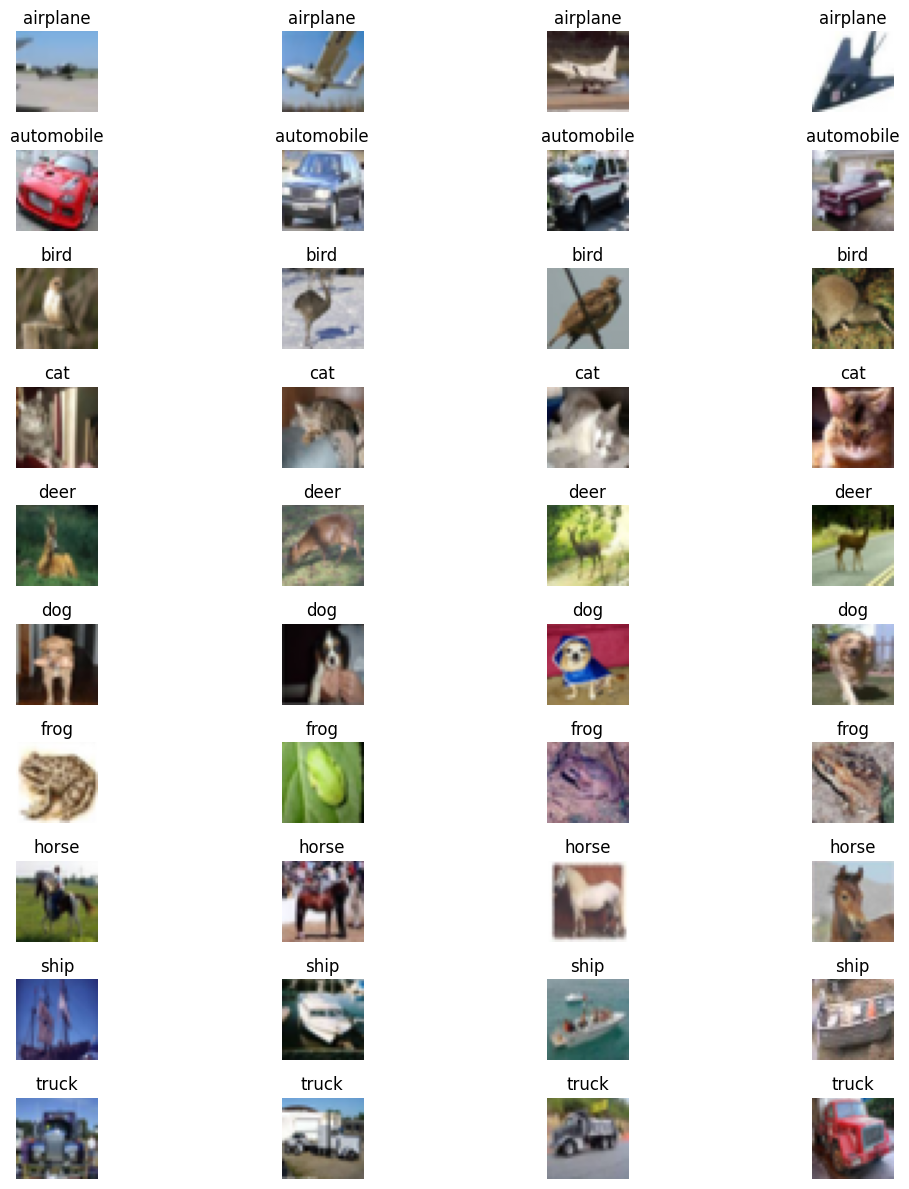

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(12, 12))
for i in range(10):
    indices = np.where(y_train == i)[0]
    random_indices = np.random.choice(indices, 4, replace=False)
    for j, idx in enumerate(random_indices):
        plt.subplot(10, 4, i * 4 + j + 1)
        plt.imshow(x_train[idx])
        plt.title(class_names[i])
        plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 109s 144ms/step - accuracy: 0.3367 - loss: 1.7937 - val_accuracy: 0.5432 - val_loss: 1.2821
Epoch 2/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 98s 86ms/step - accuracy: 0.5543 - loss: 1.2434 - val_accuracy: 0.6020 - val_loss: 1.1563
Epoch 3/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 81s 85ms/step - accuracy: 0.6344 - loss: 1.0514 - val_accuracy: 0.6636 - val_loss: 0.9981
Epoch 4/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.6808 - loss: 0.9216 - val_accuracy: 0.6840 - val_loss: 0.9377
Epoch 5/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 82s 84ms/step - accuracy: 0.7093 - loss: 0.8396 - val_accuracy: 0.6976 - val_loss: 0.9003
Epoch 6/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 83s 85ms/step - accuracy: 0.7308 - loss: 0.7692 - val_accuracy: 0.7072 - val_loss: 0.8674
Epoch 7/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 81s 84ms/step - accuracy: 0.7538 - loss: 0.7040 - val_accuracy: 0.7032 - val_loss: 0.8647
Epoch 8/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 82s 84ms/step - accuracy: 0.7729 - loss: 0.6546 

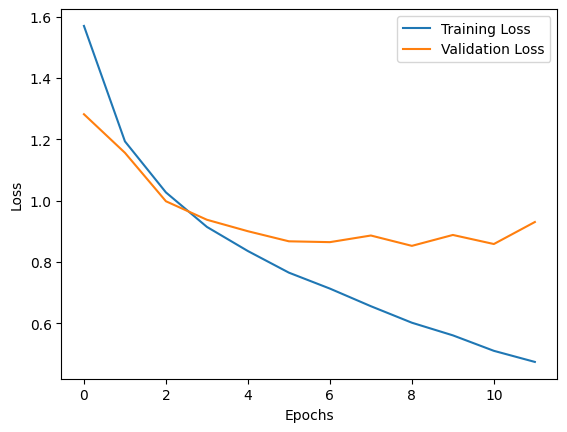

Model saved to /content/drive/MyDrive/CNN_CIFAR10_model.h5


In [ ]:
model = create_cnn_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot των loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Αποθήκευση του μοντέλου
model_path = '/content/drive/MyDrive/CNN_CIFAR10_model.h5'
model.save(model_path)
print(f"Model saved to {model_path}")


In [ ]:
#Βήμα 7: Φόρτωση του αποθηκευμένου μοντέλου

model = load_model(model_path)
print("Model loaded successfully.")


Model loaded successfully.


In [ ]:
#Βήμα 8: Υπολογισμός metrics (Accuracy, Precision, Recall, F1-score)

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate_model(model, X, y, set_name):
    y_pred = np.argmax(model.predict(X), axis=1)
    accuracy = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average='weighted')
    print(f"{set_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    return accuracy, precision, recall, f1

evaluate_model(model, x_train, y_train, "Train Set")
evaluate_model(model, x_val, y_val, "Validation Set")
evaluate_model(model, x_test, y_test, "Test Set")


1485/1485 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step
Train Set - Accuracy: 0.8226, Precision: 0.8303, Recall: 0.8226, F1-Score: 0.8240
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Validation Set - Accuracy: 0.7132, Precision: 0.7227, Recall: 0.7132, F1-Score: 0.7152
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Test Set - Accuracy: 0.7149, Precision: 0.7255, Recall: 0.7149, F1-Score: 0.7165


(0.7149, 0.7255372461410374, 0.7149, 0.7165001115828076)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


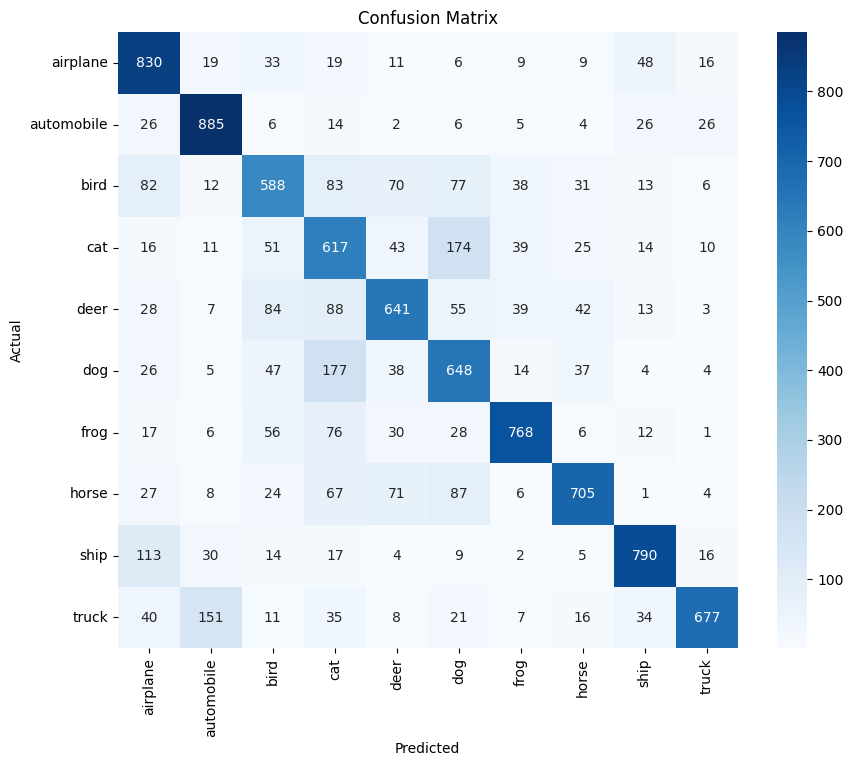

In [ ]:
#Βήμα 9: Confusion Matrix

import seaborn as sns

y_test_pred = np.argmax(model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


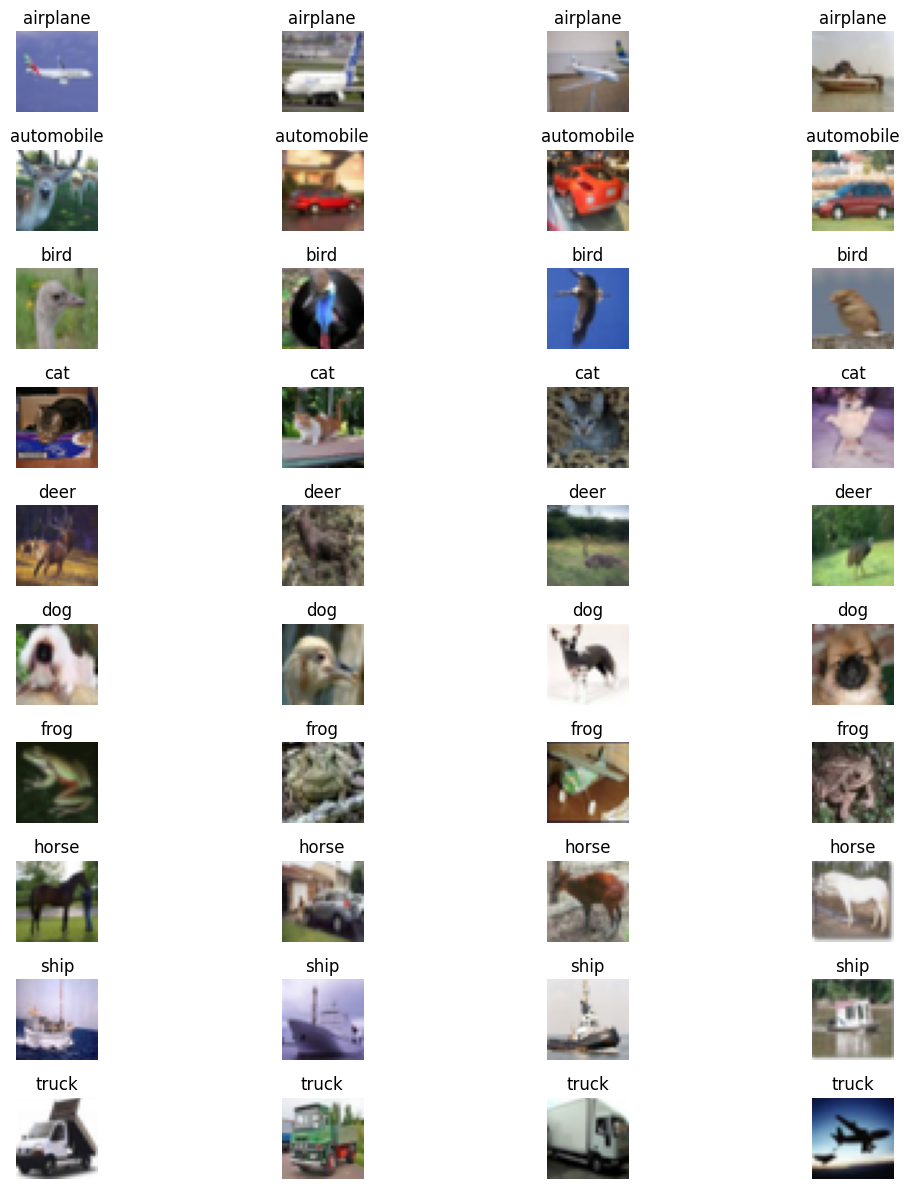

In [ ]:
#Βήμα 10: Plot 4 τυχαίων εικόνων ανά κατηγορία (με βάση το predicted class)

plt.figure(figsize=(12, 12))
for i in range(10):
    indices = np.where(y_test_pred == i)[0]
    random_indices = np.random.choice(indices, 4, replace=False)
    for j, idx in enumerate(random_indices):
        plt.subplot(10, 4, i * 4 + j + 1)
        plt.imshow(x_test[idx])
        plt.title(class_names[i])
        plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
#Stratified 5-Fold και Καταχώρηση σε DataFrame

df_results = pd.DataFrame(columns=[
    'Classifier Name', 'Set', 'Num Samples', 'Accuracy', 'Precision', 'Recall', 'F1-Score'
])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_idx, val_idx in kf.split(x_train, y_train):
    print(f"Fold {fold}/5")
    fold_model = create_cnn_model()
    fold_model.fit(x_train[train_idx], y_train[train_idx], epochs=10, batch_size=64, verbose=0)

    for set_name, X, y in [('Train', x_train[train_idx], y_train[train_idx]),
                           ('Validation', x_train[val_idx], y_train[val_idx]),
                           ('Test', x_test, y_test)]:
        acc, prec, rec, f1 = evaluate_model(fold_model, X, y, set_name)
        df_results.loc[len(df_results)] = ['CNN', set_name, len(y), acc, prec, rec, f1]
    fold += 1

print(df_results)

Fold 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step
Train - Accuracy: 0.7874, Precision: 0.8062, Recall: 0.7874, F1-Score: 0.7863
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Validation - Accuracy: 0.6903, Precision: 0.7105, Recall: 0.6903, F1-Score: 0.6878
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Test - Accuracy: 0.6911, Precision: 0.7090, Recall: 0.6911, F1-Score: 0.6878
Fold 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step
Train - Accuracy: 0.7979, Precision: 0.8100, Recall: 0.7979, F1-Score: 0.7991
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Validation - Accuracy: 0.7019, Precision: 0.7153, Recall: 0.7019, F1-Score: 0.7029
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Test - Accuracy: 0.6921, Precision: 0.7063, Recall: 0.6921, F1-Score: 0.6935
Fold 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step
Train - Accuracy: 0.8028, Precision: 0.8120, Recall: 0.8028, F1-Score: 0.8013
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Validation - Accuracy: 0.6973, Precision: 0.7074, Recall: 0.6973, F1-Score: 0.6942
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Test - Accuracy: 0.6927, Precision: 0.7005, Recall: 0.6927, F1-Score: 0.6898
Fold 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step
Train - Accuracy: 0.8187, Precision: 0.8221, Recall: 0.8187, F1-Score: 0.8178
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Validation - Accuracy: 0.6961, Precision: 0.7015, Recall: 0.6961, F1-Score: 0.6950
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Test - Accuracy: 0.6991, Precision: 0.7058, Recall: 0.6991, F1-Score: 0.6985
Fold 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step
Train - Accuracy: 0.8232, Precision: 0.8273, Recall: 0.8232, F1-Score: 0.8214
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Validation - Accuracy: 0.6993, Precision: 0.7009, Recall: 0.6993, F1-Score: 0.6959
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Test - Accuracy: 0.6983, Precision: 0.7001, Recall: 0.6983, F1-Score: 0.6942
   Classifier Name         Set  Num Samples  Accuracy  Precision    Recall  \
0              CNN       Train        38000  0.787447   0.806250  0.787447   
1              CNN  Validation         9500  0.690316   0.710530  0.690316   
2              CNN        Test        10000  0.691100   0.709014  0.691100   
3              CNN       Train        38000  0.797947   0.810037  0.797947   
4              CNN  Validation         9500  0.701895   0.715259  0.701895   
5              CNN        Test        10000  0.692100   0.706348  0.692100   
6              CNN       Train        38000  0.802763   0.812013  0.802763   
7        